# Things to do
- Add humidity column
- Fill NaN with not NaN before
- Deal with outliers
- Add lag data (lag-2)
- Choose features columns (bit masking bruteforce)
- Modeling for test
- Modeling for forecast

### Rút kinh nghiệm sau vài lần chọn features cho model:  
    - Cột cbwd và thứ trong tuần không quá ảnh hưởng đến model nên không dùng nữa
    - Cột Ir và Is không ảnh hưởng nhiều đến model
    - Cột pres không ảnh hưởng nhiều dến model

In [1]:
import pandas as pd
import numpy as np
from math import exp, isnan
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 15, 10
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('data.csv')
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


## Add humidity column

In [4]:
def cal(temp, dewp):
    return 100*(exp((17.625*dewp)/(243.04+dewp))/exp((17.625*temp)/(243.04+temp)))
df['hum'] = [cal(temp, dewp) for temp, dewp in zip(df['TEMP'], df['DEWP'])]

## Fill NaN with not NaN previous

In [5]:
df['pm2.5'].isna().sum()

2067

In [6]:
df['pm2.5'].fillna(method='ffill', inplace=True)

In [7]:
df.dropna(inplace=True)

## Outliers

In [9]:
dic = {}
for day, month, year, hour, pm25 in zip(df['day'], df['month'], df['year'], df['hour'], df['pm2.5']):
    dic[datetime.strptime(str('{}/{}/{} {}:00'.format(int(day), int(month), int(year), int(hour))), '%d/%m/%Y %H:%M')] = pm25

In [10]:
outlier_df = pd.DataFrame.from_dict(dic, orient='index', columns=['Value'])

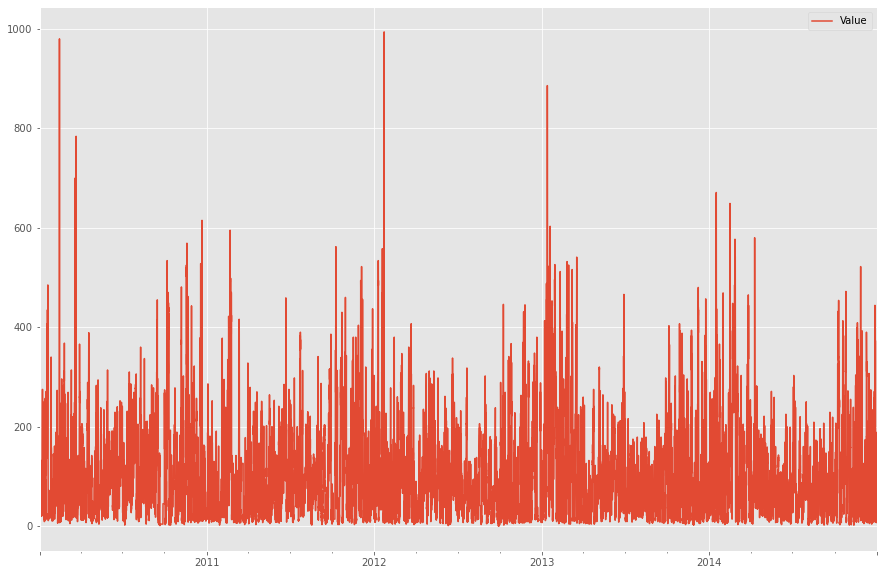

In [11]:
outlier_df.plot()
plt.show()

In [12]:
df = df[df['pm2.5'] <= 600]

In [13]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir', 'hum'],
      dtype='object')

In [15]:
need_viz = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'hum']

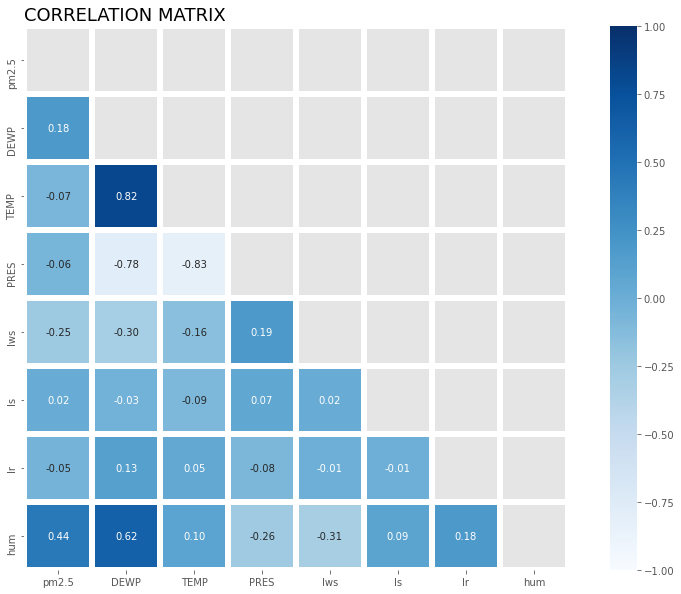

In [16]:
import seaborn as sns
data = df[need_viz].corr()
mask = np.zeros_like(data)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(data, mask=mask, annot=True, fmt='.2f', linewidth=5, cmap='Blues', vmin=-1, vmax=1, square=True)
plt.title('CORRELATION MATRIX', loc='left', fontsize=18)
plt.show()

## Lag-2

In [17]:
need_shift = ['pm2.5', 'DEWP', 'TEMP', 'Iws']
for var in need_shift:
    for i in range(1, 3):
        key = var + '_' + str(i)
        df[key] = df[var].shift(periods=i)
df.dropna(inplace=True)

<ipython-input-17-1ecb35328eb9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = df[var].shift(periods=i)
<ipython-input-17-1ecb35328eb9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [18]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1',
       'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2'],
      dtype='object')

In [19]:
# lấy những cột mà mình nghĩ nó có tác động tốt đến model
# bỏ cột cbwd
all_features = df.columns.to_list()
all_features = all_features[8:9] + all_features[10:]
print(all_features, len(all_features))

['PRES', 'Iws', 'Is', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2'] 13


## Select features and predicts columns

In [20]:
predicts = ['pm2.5', 'DEWP', 'TEMP']

#### Using binary bruteforce method
- loop over 2 ^ len(features)
- with each number, consider the 1 bit, select index at 1 bit => we have a list
- with that list, get X and y using df[list]
- throw into the model, get the score with test dataset
- update the best score with best list

In [22]:
best_score = 0
best_features = []
len_features = len(all_features)
for mask in range(2 ** len_features):
    tmp_list = []
    for index in range(len_features):
        if (mask & index):
            tmp_list.append(all_features[index])
    # list không rỗng
    if tmp_list:
        Xtrain, Xtest, ytrain, ytest = train_test_split(df[tmp_list], df[predicts])
        foo = RandomForestRegressor().fit(Xtrain, ytrain)
        score = r2_score(foo.predict(Xtest), ytest)
        if (score > best_score):
            best_score = score
            best_features = tmp_list
            print(best_score, best_features)

0.9638804258546089 ['Iws', 'Ir', 'pm2.5_1', 'DEWP_1', 'TEMP_1', 'Iws_1']
0.9640025196755948 ['Iws', 'Is', 'Ir', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'TEMP_1', 'TEMP_2', 'Iws_1']
0.9657621076342462 ['hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'Iws_2']
0.9691146024787475 ['Iws', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'TEMP_1', 'Iws_1', 'Iws_2']
0.9697790610268932 ['Is', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'TEMP_2', 'Iws_1', 'Iws_2']
0.9699408614239169 ['Iws', 'Is', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2']
0.9727266836398992 ['Iws', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2']


KeyboardInterrupt: 

In [37]:
# Có thể ngắt ô trên khi cảm thấy điểm đủ tốt

In [25]:
print(best_features)

['Iws', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2']


In [26]:
features = best_features

In [27]:
X = df[features]
y = df[predicts].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=1/4)

In [28]:
def cal_error(model, X, y):
    predict = model.predict(X)
    data = [0] * 3
    for i in range(len(predict)):
        for j in range(3):
            data[j] += abs(predict[i][j] - y[i][j])
    for i in range(3):
        data[i] /= len(predict)
    return (data[0], data[1], data[2])

In [29]:
def score_model(model, X, y):
    predict = model.predict(X)
    print('R^2 score:', r2_score(predict, y))
    print('Mean Absolute Error:', mean_absolute_error(predict, y))
    print('Error model:', cal_error(model, X, y))

In [30]:
def important_features(model, features):
    foo = pd.Series(model.feature_importances_, index=features)
    foo.nlargest(100).plot(kind='barh')
    plt.show()

## Modeling

### Split train and test data for testing

In [31]:
random_forest_test = RandomForestRegressor()

# use partial dataset
random_forest_test.fit(Xtrain, ytrain)
random_forest_test.score(Xtrain, ytrain)

0.996117454334264

In [32]:
score_model(random_forest_test, Xtest, ytest)

R^2 score: 0.9703696418070983
Mean Absolute Error: 4.883033949771016
Error model: (12.64972306004939, 0.9211717393291349, 1.0782070499345242)


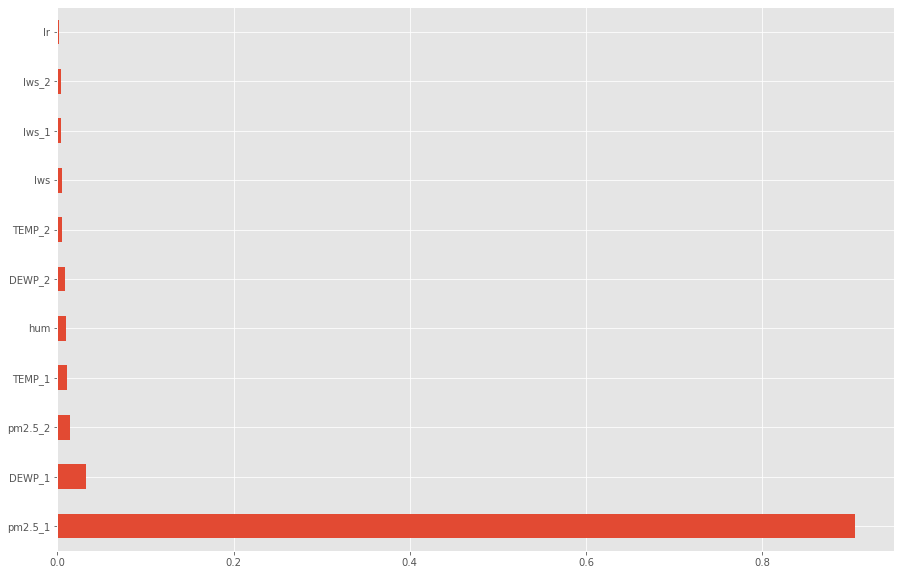

In [33]:
important_features(random_forest_test, features)

### Use whole dataset for modeling, use for forecast

In [34]:
random_forest = RandomForestRegressor()
random_forest.fit(X, y)
random_forest.score(X, y)

0.9962163419380291

## Predict for next 6 hours

In [35]:
for i in range(6):
    tail = pd.concat([df.tail(1)], ignore_index=True)
    tail.loc[:, ['day', 'month', 'year', 'hour']] = [1, 1, 2015, i]
    df = pd.concat([df, tail], ignore_index=True)
    df.loc[len(df) - 1:, predicts] = random_forest.predict(tail[features])
    for var in need_shift:
        for i in range(1, 3):
            key = var + '_' + str(i)
            df[key] = df[var].shift(periods=i)

In [36]:
df.tail(6)[['day', 'month', 'year', 'hour'] + predicts]

,day,month,year,hour,pm2.5,DEWP,TEMP
43763,1,1,2015,0,11.22,-21.23,-3.31
43764,1,1,2015,1,12.98,-21.35,-3.60
43765,1,1,2015,2,10.60,-21.11,-3.40
43766,1,1,2015,3,14.20,-21.34,-3.88
43767,1,1,2015,4,12.14,-21.16,-3.52
43768,1,1,2015,5,14.05,-21.26,-3.89


### Note:
- season
- trend
- statistical models for time serries
- how data transform by times (up or down, low or high)
- past data for weekdays or for pm2.5 last year
- k fold cross validation for time series